In [1]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

2024-08-20 17:53:08.818928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download Food-5k dataset

https://www.kaggle.com/binhminhs10/food5k/downloads/food5k.zip

In [2]:
training_dir = 'data/train/'
valid_dir = 'data/val/'
test_dir = 'data/test/'

img_width, img_height = 256, 256
batch_size = 32
epochs = 50

## Data Generators

In [3]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = 'binary'
)

valid_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

valid_generator = valid_datagen.flow_from_directory(
                        valid_dir,
                        target_size = (img_height, img_width),
                        batch_size = batch_size, 
                        class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

test_generator = valid_datagen.flow_from_directory(
                        test_dir,
                        target_size = (img_height, img_width),
                        batch_size = 16, 
                        class_mode = 'binary')

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
for X, y in train_generator:
    break

In [21]:
X, y = next(train_generator)
y

array([1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [22]:
valid_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

valid_generator = valid_datagen.flow_from_directory(
                        valid_dir,
                        target_size = (img_height, img_width),
                        batch_size = batch_size, 
                        class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

test_generator = valid_datagen.flow_from_directory(
                        test_dir,
                        target_size = (img_height, img_width),
                        batch_size = 16, 
                        class_mode = 'binary')

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
import numpy as np

In [25]:
np.unique(train_generator.classes)

array([0, 1], dtype=int32)

In [26]:
imgs, labels = next(train_generator)

In [27]:
imgs.shape

(32, 256, 256, 3)

In [28]:
labels

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

## Image samples

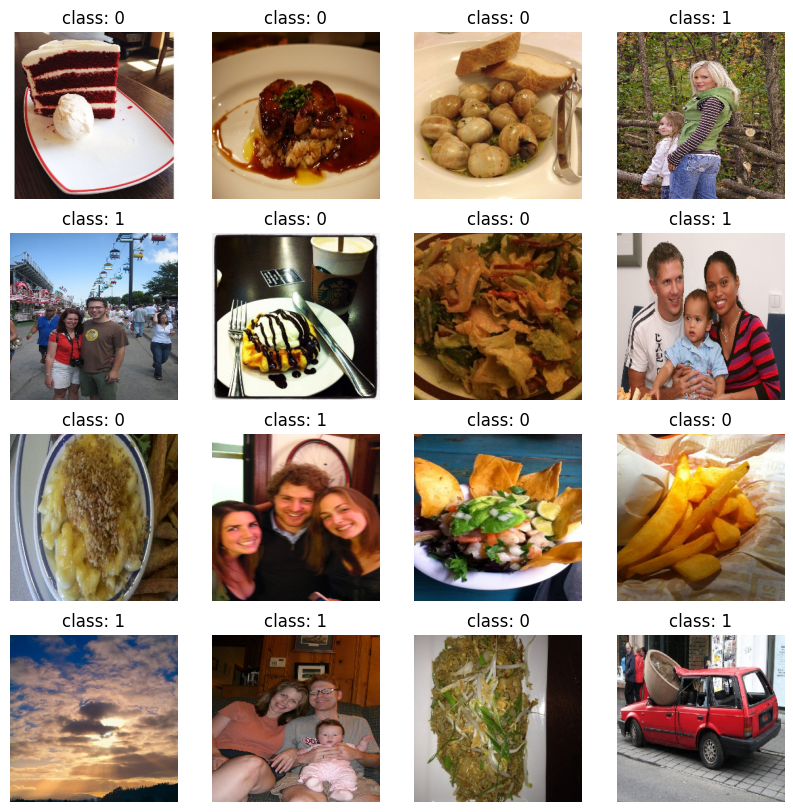

In [29]:

num_figs = 16

fig, axs = plt.subplots(num_figs // 4, 4, figsize=(10,10))
for i in range(num_figs):
    axs[i // 4, i % 4].imshow(imgs[i])
    axs[i // 4, i % 4].axis('off')
    axs[i // 4, i % 4].set_title(f'class: {int(labels[i])}')
plt.show()

## Load VGG model

In [34]:
model = applications.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (img_width, img_height, 3)
)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Freeze layers

In [17]:
model.layers

In [35]:
last_freezed_layer = 5
for n, layer in enumerate(model.layers):
    if n>last_freezed_layer:
        layer.trainable = True
    else:
        layer.trainable = False

In [37]:
model.output

<KerasTensor shape=(None, 8, 8, 512), dtype=float32, sparse=False, name=keras_tensor_102>

## Add custom layers

In [38]:
x_out = model.output
gap_out = GlobalAveragePooling2D()(x_out)
x_dense = Dense(512, activation="relu")(gap_out)
x_do = Dropout(0.5)(x_dense)
output = Dense(1, activation="sigmoid")(x_do)

model_final = Model(inputs = model.input, outputs = output)

In [39]:
model_final.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [45]:
# creating the final model 


# compile the model 
model_final.compile(
    loss = "binary_crossentropy", 
    optimizer = optimizers.Adam(learning_rate=0.001), 
    metrics=["accuracy"]
)

In [47]:
train_generator.n // batch_size

93

## Model Fit

In [55]:
# Save the model according to the conditions  
checkpoint_file = "vgg16_1.weights.h5"

checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_accuracy', verbose=1, save_best_only=True,
                             save_weights_only=True, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')


# Train the model 
hist = model_final.fit(
    train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks = [checkpoint, early],
    verbose = 1
)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9463 - loss: 0.1369
Epoch 1: val_accuracy improved from -inf to 0.94456, saving model to vgg16_1.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 742s 8s/step - accuracy: 0.9463 - loss: 0.1368 - val_accuracy: 0.9446 - val_loss: 0.1189
Epoch 2/50
 1/93 ━━━━━━━━━━━━━━━━━━━━ 10:20 7s/step - accuracy: 0.9375 - loss: 0.2281

2024-08-20 19:43:59.986742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/julian/opt/anaconda3/envs/cnns/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.94456 to 1.00000, saving model to vgg16_1.weights.h5


2024-08-20 19:44:01.886811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9375 - loss: 0.2281 - val_accuracy: 1.0000 - val_loss: 0.0667
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9531 - loss: 0.1176
Epoch 3: val_accuracy did not improve from 1.00000
93/93 ━━━━━━━━━━━━━━━━━━━━ 830s 9s/step - accuracy: 0.9531 - loss: 0.1176 - val_accuracy: 0.9617 - val_loss: 0.1107
Epoch 4/50
 1/93 ━━━━━━━━━━━━━━━━━━━━ 8:38 6s/step - accuracy: 0.9375 - loss: 0.1035

2024-08-20 19:57:58.264926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy did not improve from 1.00000
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9375 - loss: 0.1035 - val_accuracy: 1.0000 - val_loss: 0.0165
Epoch 5/50


2024-08-20 19:58:00.037864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9542 - loss: 0.1196
Epoch 5: val_accuracy did not improve from 1.00000
93/93 ━━━━━━━━━━━━━━━━━━━━ 729s 8s/step - accuracy: 0.9542 - loss: 0.1196 - val_accuracy: 0.9577 - val_loss: 0.1122
Epoch 5: early stopping


In [54]:
hist.history

NameError: name 'hist' is not defined

NameError: name 'hist' is not defined

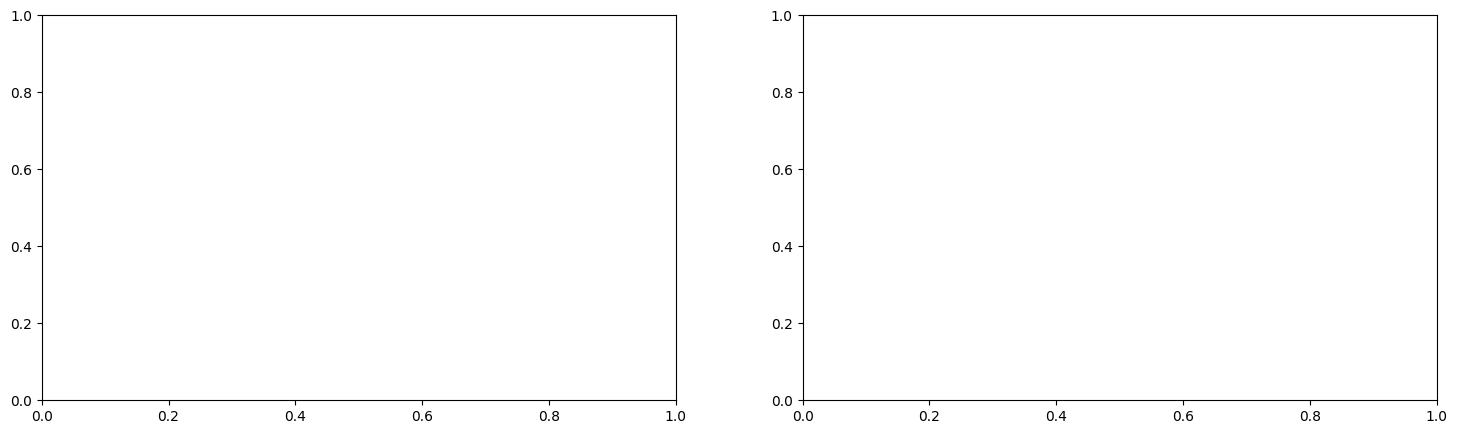

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(18,5))

axs[0].plot(hist.history['loss'], label='Train')
axs[0].plot(hist.history['val_loss'], label='Valid')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(hist.history['accuracy'], label='Train')
axs[1].plot(hist.history['val_accuracy'], label='Valid')
axs[1].set_title('Accuracy')
axs[1].legend()
fig.show()

In [109]:
checkpoint_file

'vgg16_1.h5'

In [110]:
# model_final.load_weights(checkpoint_file)

loss, acc = model_final.evaluate_generator(test_generator, steps = test_generator.n // test_generator.batch_size)
print(f'Test Acc: {acc}')

<ipython-input-110-0b704a9e9170>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model_final.evaluate_generator(test_generator, steps = test_generator.n // test_generator.batch_size)


Test Acc: 0.944556474685669


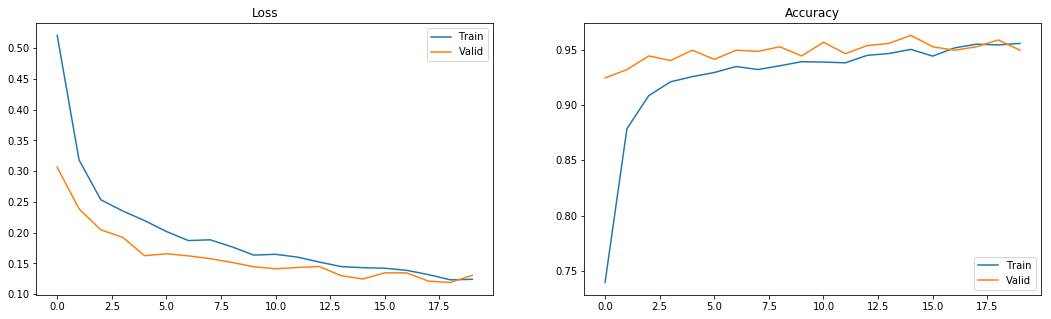

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(18,5))

axs[0].plot(hist.history['loss'], label='Train')
axs[0].plot(hist.history['val_loss'], label='Valid')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(hist.history['acc'], label='Train')
axs[1].plot(hist.history['val_acc'], label='Valid')
axs[1].set_title('Accuracy')
axs[1].legend()
fig.show()

In [43]:
model_final.load_weights(checkpoint_file)

loss, acc = model_final.evaluate_generator(test_generator, steps = test_generator.n // test_generator.batch_size)
print(f'Test Acc: {acc}')

Test Acc: 0.9465725806451613
